# Simple example of use
## Geometry

For this example we will use a simple geometry as shown in the figure below:

<img src="simple_geometry.png">

We define the geometry of the finger structure as follows:
* N: number of fingers
* L: finger overlap length
* a: finger spacing
* b: finger width

Additionally we need to define the materials:
* 3 different materials - need to specify dielectric constant along the x and y directions
* 1 material with a finite thickness

Finally there are two interfaces, and we need to define what interface the electrodes are at

In [1]:
# we start with the fingers:
N = 100 # In this example we have 1000 fingers
L = 10**-3 # We input L in meters. In this example the finger overlap length is 1 mm
a = 3*10**-6 # We here define the finger width and spacing in m, 3 µm and 2 µm correspondingly. 
b = 2*10**-6

In [2]:
# we then define the materials
# Let us assume the materials are isotropic (same dielectric constant along x and y axis)
relative_dielectric_constant_air = 1 # the relatice dielectric constant of the medium above the electrodes, let us say air
relative_dielectric_constant_film = 5 # the relatice dielectric constant of the film
relative_dielectric_constant_substrate = 2 # the relative dielectric constant of the substrate
t = 1*10**-6 # the thickness of the film in m, let us say 1 µm

## Basic use of the code
The code will let us simulate the capcitance per unit lenght of two cases:
* for a pair of electrodes part of an infinite series C_I
* for a single pair of electrodes, C_P

We can then use the following equation to calculate the capacitance of the full structure:
```
C_tot = L*((N-3)*C_I+4*C_I*C_P/(C_I*C_P))
```
(as described in the paper)

In [3]:
def get_C_tot(C_I,C_P,L,N):
    C_tot = L*((N-3)*C_I+4*C_I*C_P/(C_I+C_P))
    return C_tot

## Interacting with the code
The code is object oriented. We will create an objects that contain the geometry, and then call upon these objects to get C_I and C_P. We will start with C_I. 

The class we need is infinite_fourier.multiple_recursive_images, and requires the following input:
* etas : list of float - cover fraction of the electrode(s) must be a list of the same length as there are interfaces, i.e. 1 shorter than  eps_x_of_layers
* thickness_of_layers : list of floats - normalized thicknesses of the layers, this list will be 2 shorter than eps_x_of_layers and eps_y_of_layers, as the outermost layers have no defined thickness, but are infinite
* eps_x_of_layers : list of floats - in-plane dielectric constant of the layers
* eps_y_of_layers : list of floats - out-of-plane dielectric constant of the layers

Note that the code uses a normalized thickness, defined by the transformation:
* normalized_thickness = t/(a+b)

In [4]:
# let us transform the geometry to the form the code expects
etas = [b/(a+b),0]
thickness_of_layers = [t/(a+b)]
eps_x_of_layers = [relative_dielectric_constant_air, relative_dielectric_constant_film,relative_dielectric_constant_substrate]
eps_y_of_layers = eps_x_of_layers

In [5]:
import infinite_fourier
C_I_object = infinite_fourier.multiple_recursive_images(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers)
C_I = C_I_object.get_C()
print('C_I =',C_I, 'F/m')

C_I = 1.9175230344419248e-11 F/m


Let us now calculate C_P
for this we need pair_conformal.multiple_recursive_images, which takes the same input

In [6]:
import pair_conformal
C_P_object = pair_conformal.multiple_recursive_images(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers)
C_P = C_P_object.get_C()
print('C_P =',C_P, 'F/m')

C_P = 2.8263872430864287e-11 F/m


## The total capacitance

In [7]:
C_tot = get_C_tot(C_I,C_P,L,N)
print('C_tot =',C_tot, 'F')

C_tot = 1.905695194555167e-12 F


## Optional variables for C_I
infinite_fourier.multiple_recursive_images takes the following optional arguments:
* LAcomp: int or list of ints, optional - the number of linear algebra components used for each set of electrodes.
* max_fourier_n : int, optional - maximum number of fourier components. Note that the floating point limit is reached around 190 components, defaults to 120
* voltages : list of floats or None, optional - used for advanced geometries with multiple sets of electrodes on different interfaces
* accuracy_limit : float, optional - reflections with amplitude less than accuracy_limit are ignored, defaults to 10**-15

Of these, *LAcomp* and *max_fourier_n* may be tuned to reach a desired balance of accuracy versus speed for the desired geometry 

## Optional variables for C_P
pair_conformal.multiple_recursive_images takes the following optional arguments:
* LAcomp: same as for C_I
* max_reflections : int, optional - maximum number of reflections to considder, defaults to 8
* voltages : same as for C_I
* periods : list of floats or None - used for advanced geometries with multiple sets of electrodes on different interfaces
* accuracy_limit : same as for C_I

Of these, *LAcomp* and *max_reflections* may be tuned to reach a desired balance of accuracy versus speed for the desired geometry. *max_reflections* takes the place of *max_fourier_n* because a single pair of electrodes cannot be calculated using fourier components, so a conformal mapping aproach is used instead. 


# Visualizing the electric field
The code does not come with a visualization package. However example function for visualizing the potential used to calculate C_I and C_P are shown below. This is based on repeatedly calling .get_V on the object in question.

We start with visualizing C_I

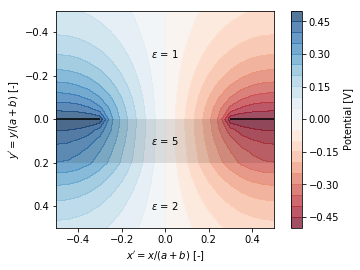

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def get_plot_pair(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers,LAcomp=8,max_fourier_n=120,num_cells=20):
    # make case
    simple_geometry_case = infinite_fourier.multiple_recursive_images(etas,thickness_of_layers,
                        eps_x_of_layers,eps_y_of_layers,LAcomp,max_fourier_n,accuracy_limit=10**-15)
    minx=-0.5
    maxx=0.5
    miny=-0.5
    maxy=0.5
    delta = (maxx-minx)/(num_cells)
    x = np.arange(minx, maxx+delta*0.5, delta)
    y = np.arange(miny, maxy+delta*0.5, delta)
    V_simple_geometry_case=np.zeros((len(y),len(x)))
    for j in range(len(y)):
        v = simple_geometry_case.get_V(x,y[j])
        V_simple_geometry_case[j,:] += v

    xx, yy = np.meshgrid(x, y)
    fig, ax = plt.subplots(1,1)
    # plot potential
    levels=np.arange(-0.5,0.51,0.05)
    CS=ax.contourf(xx,yy, V_simple_geometry_case,levels,cmap='RdBu',alpha=0.7)
    cbar=fig.colorbar(CS, ax=ax)
    ax.set_aspect('equal', 'box')
    # set_labels
    ax.set_xlabel(r"$x' = x/(a+b)$ [-]")
    ax.set_ylabel(r"$y' = y/(a+b)$ [-]")
    cbar.set_label(r'Potential [V]')
    # draw electrodes
    ax.plot([[-0.5,0.5],[-0.5+etas[0]/2,0.5-etas[0]/2]],[[0,0],[0,0]],'k',solid_capstyle='butt')
    # shade the film
    ax.add_patch(matplotlib.patches.Rectangle(
        (minx,0),   # (x,y)
        -minx+maxx,          # width
        thickness_of_layers[0],          # height
        facecolor=[0,0,0,0.1]))
    # add dielectric constant
    if eps_x_of_layers[0]==eps_y_of_layers[0]:
        ax.text(0,-0.3,r'$\varepsilon$ = '+str(eps_x_of_layers[0]), ha='center',va='center')
    else:
        ax.text(0,-0.3,r'$\varepsilon_x$ = '+str(eps_x_of_layers[0])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[0]), ha='center',va='center')
    if eps_x_of_layers[1]==eps_y_of_layers[1]:
        ax.text(0,thickness_of_layers[0]/2,r'$\varepsilon$ = '+str(eps_x_of_layers[1]), ha='center',va='center')
    else:
        ax.text(0,thickness_of_layers[0]/2,r'$\varepsilon_x$ = '+str(eps_x_of_layers[1])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[1]), ha='center',va='center')        
    if eps_x_of_layers[2]==eps_y_of_layers[2]:
        ax.text(0,0.4,r'$\varepsilon$ = '+str(eps_x_of_layers[2]), ha='center',va='center')
    else:
        ax.text(0,0.4,r'$\varepsilon_x$ = '+str(eps_x_of_layers[2])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[2]), ha='center',va='center')        
    # flip y axis
    ax.invert_yaxis()
    return fig

fig = get_plot_pair(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers)


For visualizing C_P

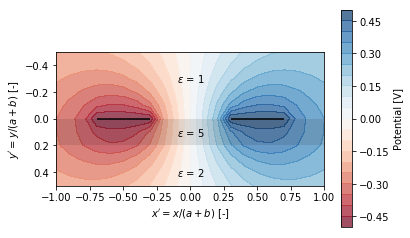

In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
def get_plot_pair(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers,LAcomp=8,max_reflections=20,num_cells=20):
    # make case
    simple_geometry_case = pair_conformal.multiple_recursive_images(etas,thickness_of_layers,
                        eps_x_of_layers,eps_y_of_layers,LAcomp,max_reflections,accuracy_limit=10**-15)
    minx=-1
    maxx=1
    miny=-0.5
    maxy=0.5
    delta = (maxx-minx)/(num_cells)
    x = np.arange(minx, maxx+delta*0.5, delta)
    y = np.arange(miny, maxy+delta*0.5, delta)
    V_simple_geometry_case=np.zeros((len(y),len(x)))
    for j in range(len(y)):
        v = simple_geometry_case.get_V(x,y[j])
        V_simple_geometry_case[j,:] += v

    xx, yy = np.meshgrid(x, y)
    fig, ax = plt.subplots(1,1)
    # plot potential
    levels=np.arange(-0.5,0.51,0.05)
    CS=ax.contourf(xx,yy, V_simple_geometry_case,levels,cmap='RdBu',alpha=0.7)
    cbar=fig.colorbar(CS, ax=ax)
    ax.set_aspect('equal', 'box')
    # set_labels
    ax.set_xlabel(r"$x' = x/(a+b)$ [-]")
    ax.set_ylabel(r"$y' = y/(a+b)$ [-]")
    cbar.set_label(r'Potential [V]')
    # draw electrodes
    ax.plot([[-0.5-etas[0]/2,0.5+etas[0]/2],[-0.5+etas[0]/2,0.5-etas[0]/2]],[[0,0],[0,0]],'k',solid_capstyle='butt')
    # shade the film
    ax.add_patch(matplotlib.patches.Rectangle(
        (minx,0),   # (x,y)
        -minx+maxx,          # width
        thickness_of_layers[0],          # height
        facecolor=[0,0,0,0.1]))
    # add dielectric constant
    if eps_x_of_layers[0]==eps_y_of_layers[0]:
        ax.text(0,-0.3,r'$\varepsilon$ = '+str(eps_x_of_layers[0]), ha='center',va='center')
    else:
        ax.text(0,-0.3,r'$\varepsilon_x$ = '+str(eps_x_of_layers[0])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[0]), ha='center',va='center')
    if eps_x_of_layers[1]==eps_y_of_layers[1]:
        ax.text(0,thickness_of_layers[0]/2,r'$\varepsilon$ = '+str(eps_x_of_layers[1]), ha='center',va='center')
    else:
        ax.text(0,thickness_of_layers[0]/2,r'$\varepsilon_x$ = '+str(eps_x_of_layers[1])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[1]), ha='center',va='center')        
    if eps_x_of_layers[2]==eps_y_of_layers[2]:
        ax.text(0,0.4,r'$\varepsilon$ = '+str(eps_x_of_layers[2]), ha='center',va='center')
    else:
        ax.text(0,0.4,r'$\varepsilon_x$ = '+str(eps_x_of_layers[2])+r' $\varepsilon_y$ = '+str(eps_y_of_layers[2]), ha='center',va='center')        
    # flip y axis
    ax.invert_yaxis()
    return fig

fig = get_plot_pair(etas,thickness_of_layers,eps_x_of_layers,eps_y_of_layers)
